Задание: обучить модель на MNIST до 97% используя PyTorch

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
import torch
torch.__version__

'0.4.1'

In [0]:
import numpy as np
import time
import torch.nn
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable
import torch.nn.functional as F

(<PIL.Image.Image image mode=L size=28x28 at 0x7FEA124BF8D0>, tensor(5))


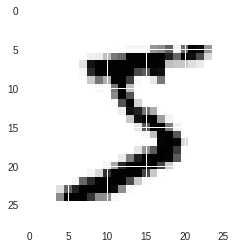

In [4]:
import torchvision

train_mnist = torchvision.datasets.MNIST('data_mnist/train', train=True, transform=None,  download=True)
test_mnist = torchvision.datasets.MNIST('data_mnist/train', train=False, transform=None, download=True)

print(train_mnist[0])
pixels = np.asarray(train_mnist[0][0])


plt.imshow(pixels)


torch.Size([1, 28, 28])


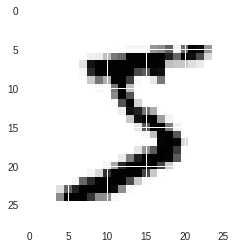

In [5]:
import torchvision.transforms as transforms
import torchvision.utils
import torch.nn as nn


train_mnist = torchvision.datasets.MNIST('data_mnist/train', train=True, transform=transforms.Compose([transforms.ToTensor()]),  download=True)
test_mnist = torchvision.datasets.MNIST('data_mnist/train', train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)

print(train_mnist[0][0].shape)
plt.imshow(train_mnist[0][0][0])

In [0]:
batch_size = 50

train_loader = torch.utils.data.DataLoader(
                 dataset=train_mnist,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_mnist,
                batch_size=batch_size,
shuffle=False)

In [0]:
class NetworkForMNIST(nn.Module):
  def __init__(self,zero_prop):
    super(NetworkForMNIST, self).__init__() 
    self.fc1 = nn.Linear(28*28,10)
    self.fc1_sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(p=zero_prop)
    
  def forward(self,x):
    y = self.dropout(self.fc1_sigmoid(self.fc1(x)))
    return y


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [20]:
device = torch.device('cuda:0' if torch.cuda else 'cpu')
EPOCH = 20
#model = NetworkForMNIST(0.2)
model = Net()
#Переводит модель в режим обучения
model.train()
model.to(device)


loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)

def accuracy(output,labels):
  predictions = torch.argmax(output,dim=1)
  correct = (predictions == labels).sum().cpu().numpy()
  return correct / len(labels)



start_time = time.time()
for epoch in range(EPOCH):
  for itr,data in enumerate(train_loader):
    imgs = data[0].to(device)
    labels = data[1].to(device)

    #imgs = imgs.view(-1,28*28)
    
    y_pred = model.forward(imgs)

    optimizer.zero_grad()
    
    loss = loss_func(y_pred,labels)
    if itr%100 == 0:
      print('Iteration {}, train accuracy {:.2f}, loss {:.4f}'.format(itr+epoch*len(train_loader),accuracy(y_pred,labels),loss))
      
    loss.backward()
    
    optimizer.step()
    
print('Total time {:.4f} seconds'.format(time.time() - start_time))

Iteration 0, train accuracy 0.06, loss 2.3201
Iteration 100, train accuracy 0.10, loss 2.3103
Iteration 200, train accuracy 0.10, loss 2.2869
Iteration 300, train accuracy 0.06, loss 2.3077
Iteration 400, train accuracy 0.12, loss 2.2858
Iteration 500, train accuracy 0.08, loss 2.3030
Iteration 600, train accuracy 0.08, loss 2.3028
Iteration 700, train accuracy 0.18, loss 2.2687
Iteration 800, train accuracy 0.16, loss 2.2768
Iteration 900, train accuracy 0.12, loss 2.2815
Iteration 1000, train accuracy 0.24, loss 2.2518
Iteration 1100, train accuracy 0.10, loss 2.2732
Iteration 1200, train accuracy 0.22, loss 2.2595
Iteration 1300, train accuracy 0.12, loss 2.2765
Iteration 1400, train accuracy 0.30, loss 2.2438
Iteration 1500, train accuracy 0.22, loss 2.2396
Iteration 1600, train accuracy 0.30, loss 2.2082
Iteration 1700, train accuracy 0.40, loss 2.1480
Iteration 1800, train accuracy 0.20, loss 2.2413
Iteration 1900, train accuracy 0.36, loss 2.1608
Iteration 2000, train accuracy 0

In [18]:
#Переводит модель в режим инференса
model.eval()

with torch.no_grad():
  accuracy_list = []
  for itr,data in enumerate(test_loader):
    imgs = data[0].to(device)
    labels = data[1].to(device)

    #imgs = imgs.view(-1,28*28)
    
    y_pred = model.forward(imgs)
    accuracy_list.append(accuracy(y_pred,labels))

print('Test accuracy - {:.2f}'.format(np.sum(accuracy_list)/len(accuracy_list)))

Test accuracy - 0.97
